# Autoencoder-for-Syslog-Log-Anomaly-Detection

시간을 기준으로 한 Syslog 데이터를 이용하여 Autoencoder Anomaly Detection 진행.

---

## Simple EDA

In [59]:
# 파일 확인
!ls "./data"

ha2.txt_structured.csv		 HDFS_100k.log_structured.csv  model_plot.png
ha2.txt_templates.csv		 log_model_HDFS.h5	       weblog.csv
HDFS_100k.log_anomaly_label.csv  LSTM_model_plot.png


In [60]:
# import section
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model, Sequential
from keras.layers import Dense, Input, LSTM ,Embedding , RepeatVector, TimeDistributed
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd

## Neural Netowork Autoencoder 
logparser의 LenMa 를 적용한 데이터

In [61]:
struct_log = './data/ha2.txt_structured.csv' # The structured log file

In [62]:
df = pd.read_csv(struct_log)

In [63]:
df

,LineId,date,time,ip,Content,EventId,EventTemplate
0,1,2021-01-19,10:30:48,172.30.171.22,"BENIT_Client IP1 : 114.119.158.142, user_no : ...",73aa200a,"BENIT_Client <*> : <*>, user_no : session_id ..."
1,2,2021-01-19,10:30:48,172.30.171.22,"BENIT_Client IP2 : 114.119.158.142, user_no : ...",41de2f67,"BENIT_Client <*> : <*>, user_no : null, Header..."
2,3,2021-01-19,10:30:04,121.135.187.201,"BENIT_Client IP2 : 203.225.82.146, user_no : n...",c06227d3,"BENIT_Client <*> : <*>, user_no : null, Header..."
3,4,2021-01-19,10:30:04,121.135.187.201,"BENIT_Client IP2 : 203.225.82.146, user_no : n...",6d35b111,"BENIT_Client <*> : <*>, user_no : null, Header..."
4,5,2021-01-19,10:30:04,121.135.187.201,"BENIT_Client IP1 : 203.225.82.146, user_no : n...",73aa200a,"BENIT_Client <*> : <*>, user_no : session_id ..."
...,...,...,...,...,...,...,...
9995,9996,2021-01-18,21:42:43,203.225.59.78,javax.mail.AuthenticationFailedException: AUTH...,9dd86978,javax.mail.AuthenticationFailedException: AUTH...
9996,9997,2021-01-18,21:42:43,203.225.59.78,Caused by: javax.mail.AuthenticationFailedExce...,e7b43955,Caused by: javax.mail.AuthenticationFailedExce...
9997,9998,2021-01-18,21:42:43,203.225.59.78,Caused by: javax.mail.AuthenticationFailedExce...,e7b43955,Caused by: javax.mail.AuthenticationFailedExce...
9998,9999,2021-01-18,21:42:43,203.225.59.78,com.thinkm.mink.commons.exection.MinkException...,a7e71bf9,com.thinkm.mink.commons.exection.MinkException...


In [64]:
# simple EDA
df.isna().sum()

LineId           0
date             0
time             0
ip               0
Content          0
EventId          0
EventTemplate    0
dtype: int64

In [65]:
# simple EDA
for i in df.columns:
    print(i)
    print(df[i].unique())
    print(len(df[i].unique()))
    print(' === ')

LineId
[    1     2     3 ...  9998  9999 10000]
10000
 === 
date
['2021-01-19' '2021-01-18']
2
 === 
time
['10:30:48' '10:30:04' '10:29:57' ... '21:43:05' '21:42:56' '21:42:43']
3510
 === 
ip
['172.30.171.22' '121.135.187.201' '203.225.59.197' '203.225.27.66'
 '203.225.2.126' '203.225.2.70' '203.225.25.44' '203.225.27.222'
 '203.225.59.218' '203.225.252.60' '172.30.151.95' '203.225.2.125'
 '203.225.1.106' '203.225.1.78' '203.225.1.168' '203.225.1.159'
 '203.225.255.108' '203.225.2.138' '203.225.2.17' '203.225.59.78']
20
 === 
Content
['BENIT_Client IP1 : 114.119.158.142, user_no : null, session_id : uYIYQ_ShY4w8YzbXKQo1Kghyp7WswskiD0aXwY9BKCL9MQRQkwV3!-602321484!1611019842721, is_new : true, create_time : 20210119 10:30:42, last_access_time : 20210119 10:30:42, interval_time : 1800'
 'BENIT_Client IP2 : 114.119.158.142, user_no : null, Header Info : {X-WebLogic-KeepAliveSecs=30, Accept-Language=en,zh;q=0.1, Host=dream.kolon.com, Accept-Encoding=gzip,deflate, X-Forwarded-For=114.119.15

### Train

In [66]:
from utils import dataloader
from utils.preprocessing import Vectorizer_sys


batch_size = 32
hidden_size = 32
num_directions = 2
topk = 5
train_ratio = 0.2
window_size = 10
epoches = 2
num_workers = 2
device = 0 

x_, window_y_ = \
dataloader.load_sys_time(struct_log, window='session', window_size=window_size, train_ratio=train_ratio, split_type='uniform')

====== Input data summary ======
Loading ./data/ha2.txt_structured.csv
Slicing 769 sessions, with window 10
Slicing done, 4191 windows generated
Train: windows


In [67]:
x_.EventSequence[0]

[296, 297, 298, 298, 299, 296, 296, 297, 298, 1]

In [68]:
window_y_

0        327
1       #Pad
2          1
3         12
4          1
        ... 
4186       1
4187       5
4188       5
4189    #Pad
4190    #Pad
Name: Label, Length: 4191, dtype: object

In [69]:
feature_extractor = Vectorizer_sys()
train_dataset = feature_extractor.fit_transform(x_, window_y_)

In [70]:
train_dataset

{'SessionId': array([  0,   0,   1, ..., 767, 767, 768]),
 'window_y': array([ 2,  1,  4, ..., 61,  1,  1]),
 'x': array([[ 22,  23,  13, ...,  23,  13,   4],
        [ 23,  13,  13, ...,  13,   4,   2],
        [  4,  28,  29, ...,  43,   4,  15],
        ...,
        [140,   4,  10, ...,  69,   4,  61],
        [  4,  10, 140, ...,   4,  61,  61],
        [ 29,  28,   4, ...,   1,   1,   1]])}

In [71]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='./data/log_model_HDFS.h5'
    )
]

In [72]:
# NN Autoencoder model.
input_dim = train_dataset['x'].shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(input_dim//3*2, activation='relu')(input)
encode = Dense(input_dim//3, activation='relu')(encode)
encode = Dense(1, activation='relu')(encode)

decode = Dense(input_dim//3, activation='relu')(encode)
decode = Dense(input_dim//3*2, activation='relu')(decode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

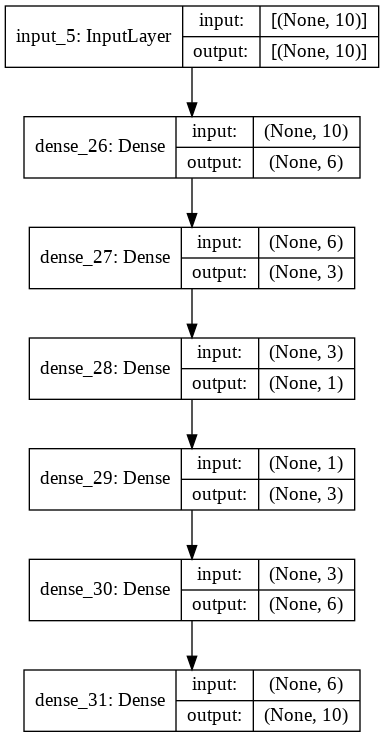

In [73]:
plot_model(autoencoder, to_file='./data/model_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
# Create 6 layer model.
input_dim = train_dataset['x'].shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(input_dim//3*2, activation='relu')(input)
encode = Dense(input_dim//3, activation='relu')(encode)
encode = Dense(1, activation='relu')(encode)

decode = Dense(input_dim//3, activation='relu')(encode)
decode = Dense(input_dim//3*2, activation='relu')(decode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

# Train model.
history = autoencoder.fit(train_dataset['x'], train_dataset['x'],
        epochs=200,
        batch_size=128,
        callbacks=callbacks_list,
        shuffle=True
        )

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 66        
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 4         
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 6         
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 24        
_________________________________________________________________
dense_37 (Dense)             (None, 10)                70  

### Check the result

In [75]:
import pandas as pd

# Combined x and x_test.
new_x = train_dataset['x']

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quartile.
threshold = error_df.quantile(0.99)

error_df.describe()

,reconstruction_error
count,4191.000000
mean,3746.748909
std,5330.386979
min,15.516730
25%,559.549558
50%,1599.487994
75%,4622.639613
max,42527.521256


(array([3356.,  507.,  206.,   72.,   29.,   14.,    7.]),
 array([1.55167303e+01, 6.08866023e+03, 1.21618037e+04, 1.82349472e+04,
        2.43080907e+04, 3.03812342e+04, 3.64543778e+04, 4.25275213e+04]),
 <a list of 7 Patch objects>)

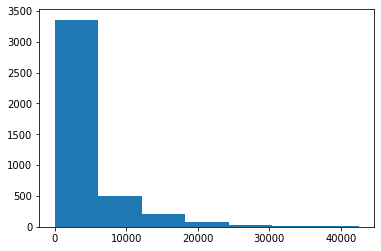

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

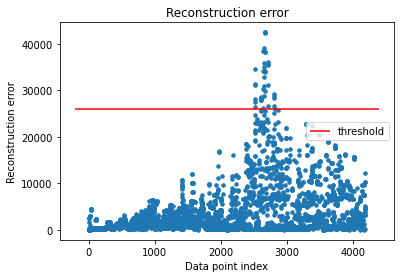

In [77]:
threshold = threshold

# Plot reconstruction error vs. the data.
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

output = []    
for x in index_list:
    output.append(new_x[x])


## LSTM Autoencoder

In [78]:
x = np.expand_dims(train_dataset['x'],axis=1)


In [79]:
# LSTM Autoencoder
model = Sequential()

# Encoder
model.add(LSTM(8, activation='relu', input_shape=(1,10), return_sequences=True))
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(1, activation='relu', return_sequences=True))
# model.add(RepeatVector(10))

# Decoder
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(8, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(10)))

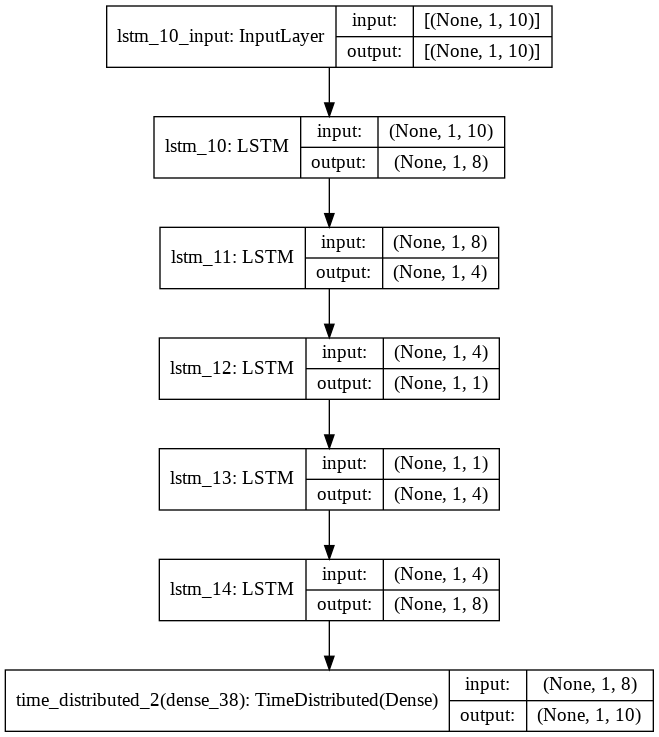

In [80]:
plot_model(model, to_file='./data/LSTM_model_plot.png', show_shapes=True, show_layer_names=True)

In [81]:
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

# fit
history = model.fit(x, x,
                     epochs=200, batch_size=128)

Epoch 1/200
33/33 [==============================] - 6s 24ms/step - loss: 3816.6089 - accuracy: 0.0997
Epoch 2/200
33/33 [==============================] - 1s 21ms/step - loss: 3945.4413 - accuracy: 0.1015
Epoch 3/200
33/33 [==============================] - 1s 23ms/step - loss: 3765.2476 - accuracy: 0.1009
Epoch 4/200
33/33 [==============================] - 1s 20ms/step - loss: 3770.8654 - accuracy: 0.1004
Epoch 5/200
33/33 [==============================] - 1s 23ms/step - loss: 3638.6628 - accuracy: 0.0936
Epoch 6/200
33/33 [==============================] - 1s 21ms/step - loss: 2895.5085 - accuracy: 0.1003
Epoch 7/200
33/33 [==============================] - 1s 21ms/step - loss: 2426.8522 - accuracy: 0.1017
Epoch 8/200
33/33 [==============================] - 1s 22ms/step - loss: 2221.7980 - accuracy: 0.0970
Epoch 9/200
33/33 [==============================] - 1s 23ms/step - loss: 2171.7175 - accuracy: 0.1052
Epoch 10/200
33/33 [==============================] - 1s 21ms/step - loss